# 🇺🇦 Ukrainian OCR Pipeline - Full Component Demo

This notebook demonstrates the complete OCR pipeline step-by-step using individual components:

1. **Kraken Segmentation** - Detect text lines in document images
2. **TrOCR Recognition** - Recognize Cyrillic handwritten text
3. **ALTO Creation** - Generate standard ALTO XML format
4. **NER Extraction** - Extract named entities (persons, locations)
5. **ALTO Enhancement** - Add NER annotations to ALTO XML

Perfect for understanding the pipeline internals and custom workflows.

## 📦 Setup and Imports

In [26]:
# Core imports
import os
import sys
import time
import json
from pathlib import Path
from typing import List, Dict, Optional

# Add package to path if running from examples directory
if os.path.exists('../ukrainian_ocr'):
    sys.path.insert(0, '..')
    print("✅ Using development version from parent directory")

# Image processing
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# XML processing
import xml.etree.ElementTree as ET
from xml.dom import minidom

# PyTorch
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

✅ Using development version from parent directory
PyTorch version: 2.7.1+cu126
CUDA available: False
Using device: cpu


## 🖼️ Load Test Image

✅ Test image: 804-03494422-l-m-a-n2982-4-1001-00004.jpg
   Size: 1.4MB
   Dimensions: 3946x2589


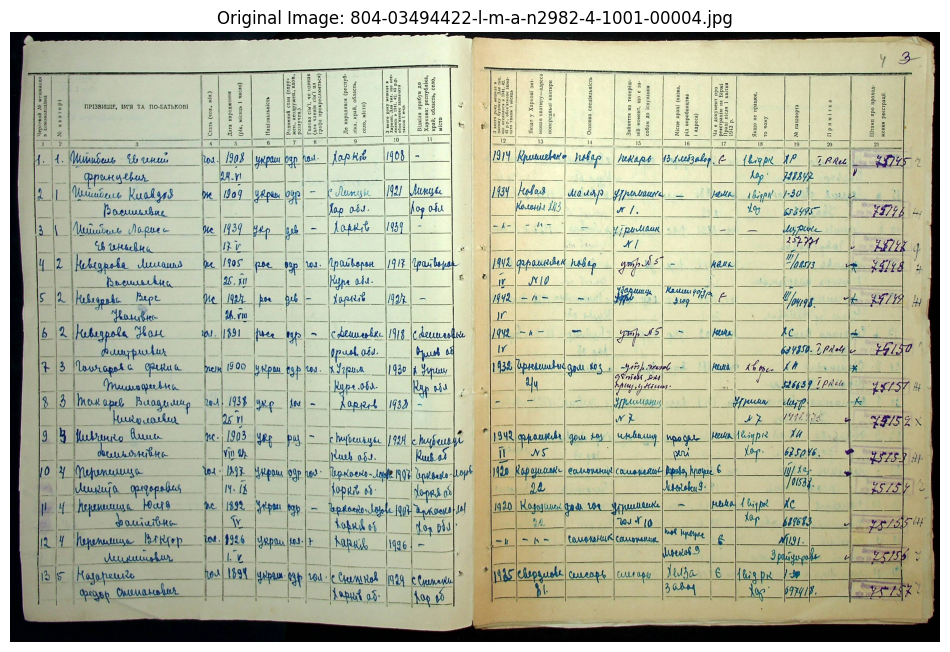

In [28]:
# Define test image path - modify for your setup
test_image_path = "/home/maria/ssd990/projects/tarkovsky/Н-2982_4_1001/804-03494422-l-m-a-n2982-4-1001-00004.jpg"

# Alternative: use any test image
# test_image_path = "path/to/your/test/image.jpg"

# Check if image exists
if os.path.exists(test_image_path):
    print(f"✅ Test image: {os.path.basename(test_image_path)}")
    print(f"   Size: {os.path.getsize(test_image_path) / 1024 / 1024:.1f}MB")
    
    # Load image
    image = cv2.imread(test_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    print(f"   Dimensions: {width}x{height}")
    
    # Display image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.title(f"Original Image: {os.path.basename(test_image_path)}")
    plt.axis('off')
    plt.show()
else:
    print(f"❌ Image not found: {test_image_path}")
    print("Please update test_image_path with a valid image path")

## 1️⃣ Kraken Segmentation

Use Kraken BLLA (Baseline Layout Analysis) to detect text lines in the document.

In [29]:
from ukrainian_ocr.core.segmentation import KrakenSegmenter

print("🔍 Initializing Kraken segmenter...")
segmenter = KrakenSegmenter(device=device)
print(f"✅ Segmenter ready (device: {segmenter.device})")

🔍 Initializing Kraken segmenter...
✅ Segmenter ready (device: cpu)


In [30]:
# Perform segmentation
print("🔄 Segmenting image...")
start_time = time.time()

lines = segmenter.segment_image(image)

seg_time = time.time() - start_time
print(f"✅ Segmentation complete in {seg_time:.2f}s")
print(f"📊 Found {len(lines)} text lines")

# Show line details
if lines:
    print("\n📝 Sample lines (first 5):")
    for i, line in enumerate(lines[:5]):
        bbox = line.get('bbox', [])
        polygon = line.get('polygon', [])
        print(f"  Line {i+1}:")
        print(f"    ID: {line.get('id', 'N/A')}")
        print(f"    BBox: {bbox[:4] if len(bbox) >= 4 else 'N/A'}")
        print(f"    Polygon points: {len(polygon)}")
        print(f"    Confidence: {line.get('confidence', 0):.2f}")

🔄 Segmenting image...


Polygonizer failed on line 0: TopologyException: side location conflict at 591.00036157995976 303.95805672466412. This can occur if the input geometry is invalid.


✅ Segmentation complete in 49.86s
📊 Found 336 text lines

📝 Sample lines (first 5):
  Line 1:
    ID: line_0
    BBox: [112.0, 288.0, 151.0, 356.0]
    Polygon points: 5
    Confidence: 1.00
  Line 2:
    ID: line_1
    BBox: [124.0, 409.0, 174.0, 465.0]
    Polygon points: 4
    Confidence: 1.00
  Line 3:
    ID: line_2
    BBox: [184.0, 404.0, 233.0, 465.0]
    Polygon points: 4
    Confidence: 1.00
  Line 4:
    ID: line_3
    BBox: [302.0, 288.0, 771.0, 357.0]
    Polygon points: 8
    Confidence: 1.00
  Line 5:
    ID: line_4
    BBox: [112.0, 495.0, 689.0, 599.0]
    Polygon points: 13
    Confidence: 1.00


🎨 Creating segmentation visualization...


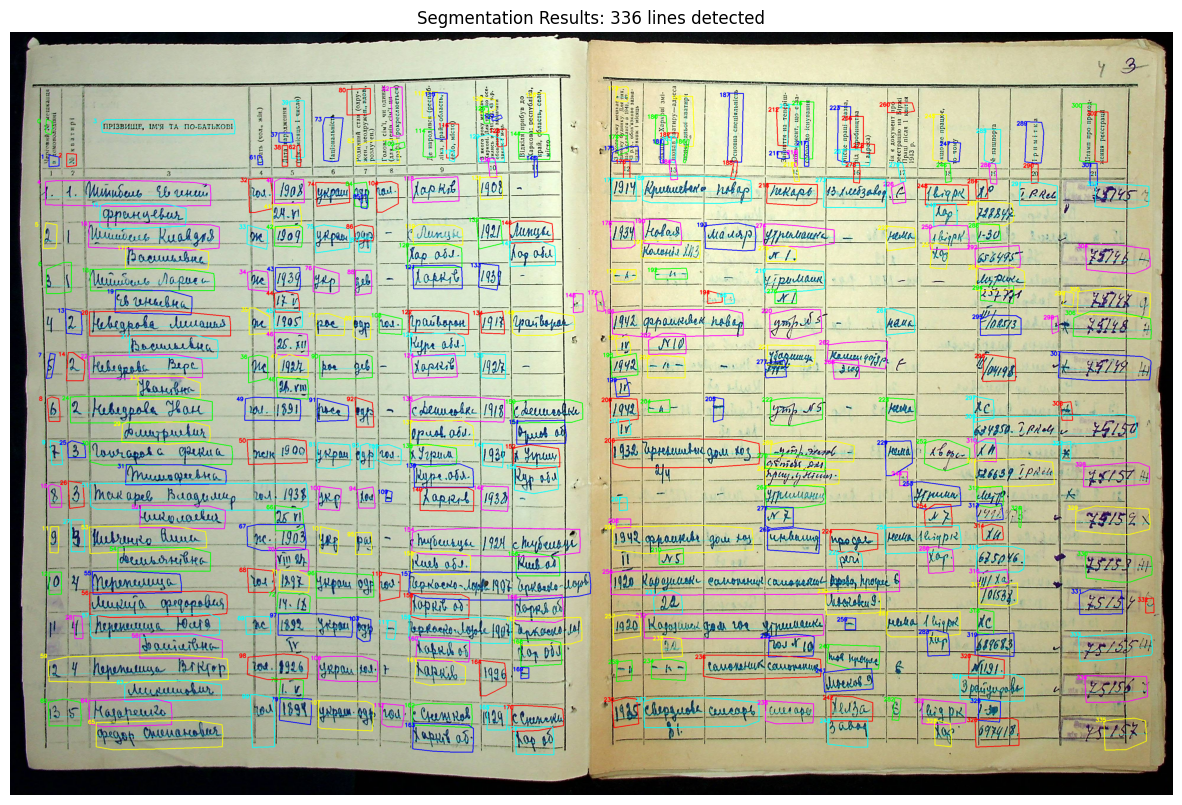

💾 Visualization saved to: segmentation_result.png


In [31]:
# Visualize segmentation
print("🎨 Creating segmentation visualization...")

# Create visualization manually since KrakenSegmenter doesn't have this method
vis_image = image.copy()

# Draw each line with different colors for visibility
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

for idx, line in enumerate(lines):
    # Choose color
    color = colors[idx % len(colors)]
    
    # Draw polygon if available (preferred)
    polygon = line.get('polygon', [])
    if polygon and len(polygon) >= 3:
        pts = np.array(polygon, np.int32)
        cv2.polylines(vis_image, [pts], True, color, 2)
    else:
        # Fallback to bbox if no polygon
        bbox = line.get('bbox', [])
        if len(bbox) >= 4:
            x1, y1, x2, y2 = map(int, bbox[:4])
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)
    
    # Draw baseline if available (in cyan)
    baseline = line.get('baseline', [])
    if baseline and len(baseline) >= 2:
        baseline_pts = np.array(baseline, np.int32)
        cv2.polylines(vis_image, [baseline_pts], False, (255, 255, 0), 1)
    
    # Add line number for reference
    bbox = line.get('bbox', [])
    if len(bbox) >= 4:
        x1, y1 = int(bbox[0]), int(bbox[1])
        cv2.putText(vis_image, str(idx), (x1 - 20, y1 + 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Display the visualization
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
plt.title(f"Segmentation Results: {len(lines)} lines detected")
plt.axis('off')
plt.show()

# Save visualization
vis_path = "segmentation_result.png"
cv2.imwrite(vis_path, vis_image)
print(f"💾 Visualization saved to: {vis_path}")

## 2️⃣ TrOCR Text Recognition

Use TrOCR model to recognize Cyrillic handwritten text in each line.

In [32]:
from ukrainian_ocr.core.ocr import TrOCRProcessor

print("🤖 Initializing TrOCR processor...")
print("📥 This may take a moment on first run (downloading model)")

ocr_processor = TrOCRProcessor(
    model_path="cyrillic-trocr/trocr-handwritten-cyrillic",
    device=device,
    batch_size=4 if device == 'cuda' else 1
)

print(f"✅ OCR processor ready (device: {ocr_processor.device})")
print(f"   Model: {ocr_processor.model_path}")
print(f"   Batch size: {ocr_processor.batch_size}")

🤖 Initializing TrOCR processor...
📥 This may take a moment on first run (downloading model)


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 6223.00it/s]


✅ OCR processor ready (device: cpu)
   Model: cyrillic-trocr/trocr-handwritten-cyrillic
   Batch size: 1


In [33]:
# Recognize text in lines
print(f"🔄 Recognizing text in {len(lines)} lines...")
print("⏳ This may take several minutes depending on document size")

start_time = time.time()
lines_with_text = ocr_processor.process_lines(image, lines)
ocr_time = time.time() - start_time

print(f"✅ OCR complete in {ocr_time:.2f}s")

# Count successful recognitions
recognized_lines = [l for l in lines_with_text if l.get('text', '').strip()]
print(f"📊 Recognized text in {len(recognized_lines)}/{len(lines)} lines")

# Show sample results
print("\n📝 Sample recognized text (first 10 lines with text):")
for i, line in enumerate([l for l in lines_with_text if l.get('text', '').strip()][:10]):
    text = line.get('text', '')
    confidence = line.get('confidence', 0)
    print(f"  {i+1}. {text} (conf: {confidence:.2f})")

🔄 Recognizing text in 336 lines...
⏳ This may take several minutes depending on document size
✅ OCR complete in 989.68s
📊 Recognized text in 336/336 lines

📝 Sample recognized text (first 10 lines with text):
  1. 2. (conf: 0.95)
  2. - (conf: 0.95)
  3. 2. (conf: 0.95)
  4. прізвише, їм'я та по-батькові. (conf: 0.95)
  5. 1. 1. Шиталь Ев гений (conf: 0.95)
  6. 2 (conf: 0.95)
  7. з҃і (conf: 0.95)
  8. 5 (conf: 0.95)
  9. 6 (conf: 0.95)
  10. і (conf: 0.95)


## 3️⃣ Create Basic ALTO XML

Generate ALTO XML format from segmentation and OCR results.

In [34]:
def create_alto_xml(image_path: str, image_shape: tuple, lines: List[Dict]) -> str:
    """Create ALTO XML from processing results"""
    
    # Create ALTO structure
    alto_ns = 'http://www.loc.gov/standards/alto/ns-v4#'
    ET.register_namespace('', alto_ns)
    
    alto = ET.Element('alto', {
        'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
        'xmlns': alto_ns,
        'xsi:schemaLocation': f'{alto_ns} http://www.loc.gov/standards/alto/v4/alto-4-2.xsd'
    })
    
    # Add Description
    description = ET.SubElement(alto, 'Description')
    measurement_unit = ET.SubElement(description, 'MeasurementUnit')
    measurement_unit.text = 'pixel'
    
    source_info = ET.SubElement(description, 'sourceImageInformation')
    filename = ET.SubElement(source_info, 'fileName')
    filename.text = os.path.basename(image_path)
    
    # Add Tags
    tags = ET.SubElement(alto, 'Tags')
    
    block_tag = ET.SubElement(tags, 'OtherTag')
    block_tag.set('ID', 'BT1')
    block_tag.set('LABEL', 'text')
    block_tag.set('DESCRIPTION', 'block type text')
    
    line_tag = ET.SubElement(tags, 'OtherTag')
    line_tag.set('ID', 'LT1')
    line_tag.set('LABEL', 'default')
    line_tag.set('DESCRIPTION', 'line type default')
    
    # Add Layout
    layout = ET.SubElement(alto, 'Layout')
    page = ET.SubElement(layout, 'Page')
    page.set('ID', f'page_1')
    page.set('PHYSICAL_IMG_NR', '1')
    
    height, width = image_shape[:2]
    page.set('WIDTH', str(width))
    page.set('HEIGHT', str(height))
    
    # Add PrintSpace
    print_space = ET.SubElement(page, 'PrintSpace')
    print_space.set('HPOS', '0')
    print_space.set('VPOS', '0')
    print_space.set('WIDTH', str(width))
    print_space.set('HEIGHT', str(height))
    
    # Add TextBlock
    text_block = ET.SubElement(print_space, 'TextBlock')
    text_block.set('ID', 'block_1')
    text_block.set('TAGREFS', 'BT1')
    
    # Add text lines
    for idx, line in enumerate(lines):
        text_content = line.get('text', '').strip()
        if not text_content:
            continue
            
        text_line = ET.SubElement(text_block, 'TextLine')
        text_line.set('ID', f'line_{idx}')
        text_line.set('TAGREFS', 'LT1')
        
        # Get line coordinates
        bbox = line.get('bbox', [0, 0, 100, 30])
        if len(bbox) >= 4:
            x1, y1, x2, y2 = map(int, bbox[:4])
        else:
            x1, y1, x2, y2 = 0, idx * 30, 100, (idx + 1) * 30
            
        text_line.set('HPOS', str(x1))
        text_line.set('VPOS', str(y1))
        text_line.set('WIDTH', str(x2 - x1))
        text_line.set('HEIGHT', str(y2 - y1))
        
        # Add baseline if available
        baseline = line.get('baseline', [])
        if baseline and len(baseline) >= 2:
            baseline_str = ' '.join(f"{int(p[0])} {int(p[1])}" for p in baseline)
            text_line.set('BASELINE', baseline_str)
        
        # Add polygon if available
        polygon = line.get('polygon', [])
        if polygon and len(polygon) >= 3:
            shape = ET.SubElement(text_line, 'Shape')
            polygon_elem = ET.SubElement(shape, 'Polygon')
            points_str = ' '.join(f"{int(p[0])} {int(p[1])}" for p in polygon)
            polygon_elem.set('POINTS', points_str)
        
        # Add String element
        string = ET.SubElement(text_line, 'String')
        string.set('CONTENT', text_content)
        string.set('HPOS', str(x1))
        string.set('VPOS', str(y1))
        string.set('WIDTH', str(x2 - x1))
        string.set('HEIGHT', str(y2 - y1))
        
        # Add confidence if available
        confidence = line.get('confidence', 0.0)
        if confidence > 0:
            string.set('WC', f"{confidence:.2f}")
    
    # Convert to pretty XML
    rough_string = ET.tostring(alto, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

# Create ALTO XML
print("📄 Creating basic ALTO XML...")
basic_alto_xml = create_alto_xml(test_image_path, image.shape, lines_with_text)

# Save basic ALTO
basic_alto_path = "basic_alto.xml"
with open(basic_alto_path, 'w', encoding='utf-8') as f:
    f.write(basic_alto_xml)

print(f"✅ Basic ALTO created: {basic_alto_path}")
print(f"   Size: {os.path.getsize(basic_alto_path) / 1024:.1f}KB")

# Show sample
print("\n📋 ALTO XML preview (first 20 lines):")
for line in basic_alto_xml.split('\n')[:20]:
    print(line)

📄 Creating basic ALTO XML...
✅ Basic ALTO created: basic_alto.xml
   Size: 128.0KB

📋 ALTO XML preview (first 20 lines):
<?xml version="1.0" ?>
<alto xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="http://www.loc.gov/standards/alto/ns-v4#" xsi:schemaLocation="http://www.loc.gov/standards/alto/ns-v4# http://www.loc.gov/standards/alto/v4/alto-4-2.xsd">
  <Description>
    <MeasurementUnit>pixel</MeasurementUnit>
    <sourceImageInformation>
      <fileName>804-03494422-l-m-a-n2982-4-1001-00004.jpg</fileName>
    </sourceImageInformation>
  </Description>
  <Tags>
    <OtherTag ID="BT1" LABEL="text" DESCRIPTION="block type text"/>
    <OtherTag ID="LT1" LABEL="default" DESCRIPTION="line type default"/>
  </Tags>
  <Layout>
    <Page ID="page_1" PHYSICAL_IMG_NR="1" WIDTH="3946" HEIGHT="2589">
      <PrintSpace HPOS="0" VPOS="0" WIDTH="3946" HEIGHT="2589">
        <TextBlock ID="block_1" TAGREFS="BT1">
          <TextLine ID="line_0" TAGREFS="LT1" HPOS="112" VPOS="288" WIDTH="3

## 4️⃣ Named Entity Recognition (NER)

Extract named entities (persons, locations, organizations) from the recognized text.

In [40]:
from ukrainian_ocr.core.ner import NERExtractor

print("🏷️ Initializing NER extractor...")

# Try transformers first, then spacy, then rule-based as last resort
try:
    ner_extractor = NERExtractor(backend='transformers')
    print(f"✅ NER ready (backend: {ner_extractor.backend.get_backend_name()})")
    print("   Using transformers model (excellent quality)")
except Exception as e:
    print(f"❌ Transformers backend failed: {e}")
    try:
        ner_extractor = NERExtractor(backend='spacy')
        print(f"✅ NER ready (backend: {ner_extractor.backend.get_backend_name()})")
        print("   Using spaCy with neural model (good quality)")
    except Exception as e:
        print(f"❌ SpaCy backend failed: {e}")
        print("   Falling back to rule-based (basic quality)")
        print("   💡 Install transformers and/or spaCy for better results:")
        print("      pip install transformers torch")
        print("      pip install spacy && python -m spacy download ru_core_news_lg")
        ner_extractor = NERExtractor(backend='rule_based')

🏷️ Initializing NER extractor...


Device set to use cpu


✅ NER ready (backend: transformers_roberta_large_russian)
   Using transformers model (excellent quality)


In [41]:
# Extract entities from lines
print(f"🔍 Extracting entities from {len(lines_with_text)} lines...")

start_time = time.time()
entities_result = ner_extractor.extract_entities_from_lines(lines_with_text)
ner_time = time.time() - start_time

print(f"✅ NER complete in {ner_time:.2f}s")

# Get entity statistics
all_entities = entities_result.get('all_entities', [])
entities_by_line = entities_result.get('entities_by_line', {})

print(f"\n📊 Entity Statistics:")
print(f"  Total entities found: {len(all_entities)}")
print(f"  Lines with entities: {len(entities_by_line)}")

# Group by entity type
entity_types = {}
for entity in all_entities:
    label = entity.get('label', 'UNKNOWN')
    if label not in entity_types:
        entity_types[label] = []
    entity_types[label].append(entity.get('text', ''))

print("\n🏷️ Entities by type:")
for label, texts in entity_types.items():
    unique_texts = list(set(texts))
    print(f"  {label}: {len(texts)} occurrences ({len(unique_texts)} unique)")
    print(f"    Examples: {', '.join(unique_texts[:5])}")
    if len(unique_texts) > 5:
        print(f"    ... and {len(unique_texts) - 5} more")

🔍 Extracting entities from 336 lines...
✅ NER complete in 0.30s

📊 Entity Statistics:
  Total entities found: 0
  Lines with entities: 0

🏷️ Entities by type:


In [ ]:
# Map entities to line IDs for enhancement
print("\n🔗 Mapping entities to line IDs...")

entities_by_line_id = {}

for idx, line in enumerate(lines_with_text):
    line_id = f"line_{idx}"
    line_text = line.get('text', '')
    
    # Find entities for this line
    line_entities = []
    for entity in all_entities:
        # Check if entity appears in this line
        if entity.get('text', '') in line_text:
            line_entities.append(entity)
    
    if line_entities:
        entities_by_line_id[line_id] = {'entities': line_entities}

print(f"✅ Mapped entities to {len(entities_by_line_id)} lines")

# Show sample mapping
if entities_by_line_id:
    print("\n📝 Sample entity mappings (first 3):")
    for line_id, data in list(entities_by_line_id.items())[:3]:
        entities = data['entities']
        print(f"  {line_id}:")
        for entity in entities:
            print(f"    - {entity['text']} ({entity['label']})")
else:
    print("\n⚠️ No entities mapped to lines")

## 5️⃣ ALTO Enhancement with NER

Enhance the basic ALTO XML with named entity annotations.

In [37]:
from ukrainian_ocr.core.enhancement import ALTOEnhancer

print("🔧 Initializing ALTO enhancer...")
enhancer = ALTOEnhancer()
print("✅ Enhancer ready")

🔧 Initializing ALTO enhancer...
✅ Enhancer ready


In [38]:
# Enhance ALTO with NER
print("🎨 Enhancing ALTO with NER annotations...")

enhanced_alto_path = "enhanced_alto.xml"

start_time = time.time()
enhanced_path = enhancer.enhance_alto_with_ner(
    basic_alto_path,
    entities_by_line_id,
    enhanced_alto_path
)
enhance_time = time.time() - start_time

print(f"✅ Enhancement complete in {enhance_time:.2f}s")
print(f"📄 Enhanced ALTO saved: {enhanced_path}")

# Compare file sizes
basic_size = os.path.getsize(basic_alto_path) / 1024
enhanced_size = os.path.getsize(enhanced_path) / 1024

print(f"\n📊 File size comparison:")
print(f"  Basic ALTO: {basic_size:.1f}KB")
print(f"  Enhanced ALTO: {enhanced_size:.1f}KB")
print(f"  Size increase: {(enhanced_size/basic_size - 1)*100:.1f}%")

🎨 Enhancing ALTO with NER annotations...
✅ Enhancement complete in 0.02s
📄 Enhanced ALTO saved: enhanced_alto.xml

📊 File size comparison:
  Basic ALTO: 128.0KB
  Enhanced ALTO: 129.1KB
  Size increase: 0.8%


In [39]:
# Analyze enhanced ALTO
print("🔍 Analyzing enhanced ALTO structure...")

tree = ET.parse(enhanced_path)
root = tree.getroot()
ns = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}

# Count NER tags
tags_elem = root.find('.//alto:Tags', ns) or root.find('.//Tags')
ner_tags = []

if tags_elem is not None:
    for tag in tags_elem.findall('.//alto:OtherTag', ns) + tags_elem.findall('.//OtherTag'):
        tag_id = tag.get('ID', '')
        description = tag.get('DESCRIPTION', '')
        if 'NER_' in description:
            ner_tags.append((tag_id, description))

print(f"\n📋 NER Tags Created ({len(ner_tags)} tags):")
for tag_id, description in ner_tags:
    print(f"  {tag_id}: {description}")

# Count enhanced lines
enhanced_lines = 0
sample_enhanced_lines = []

text_lines = root.findall('.//alto:TextLine', ns) + root.findall('.//TextLine')
for line in text_lines:
    if line.get('ENTITY_TYPES') or line.get('ENTITY_TEXTS'):
        enhanced_lines += 1
        if len(sample_enhanced_lines) < 3:
            string_elem = line.find('.//alto:String', ns) or line.find('.//String')
            text = string_elem.get('CONTENT', '') if string_elem is not None else ''
            sample_enhanced_lines.append({
                'id': line.get('ID', ''),
                'text': text,
                'entity_types': line.get('ENTITY_TYPES', ''),
                'entity_texts': line.get('ENTITY_TEXTS', ''),
                'tagrefs': line.get('TAGREFS', '')
            })

print(f"\n📊 Enhancement Statistics:")
print(f"  Total lines: {len(text_lines)}")
print(f"  Lines with entities: {enhanced_lines}")
print(f"  Enhancement coverage: {enhanced_lines/len(text_lines)*100:.1f}%")

print(f"\n📝 Sample Enhanced Lines:")
for line_data in sample_enhanced_lines:
    print(f"\n  Line ID: {line_data['id']}")
    print(f"  Text: {line_data['text']}")
    print(f"  Entity Types: {line_data['entity_types']}")
    print(f"  Entity Texts: {line_data['entity_texts']}")
    print(f"  TAGREFS: {line_data['tagrefs']}")

🔍 Analyzing enhanced ALTO structure...

📋 NER Tags Created (6 tags):
  LT2: NER_PERSON
  LT3: NER_LOCATION
  LT4: NER_ORGANIZATION
  LT5: NER_MIXED
  LT6: NER_ENTITY
  BT2: NER_PERSON_DENSE_BLOCK

📊 Enhancement Statistics:
  Total lines: 336
  Lines with entities: 0
  Enhancement coverage: 0.0%

📝 Sample Enhanced Lines:


/tmp/ipykernel_2932626/3220817352.py:9: DeprecationWarning: Testing an element's truth value will raise an exception in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  tags_elem = root.find('.//alto:Tags', ns) or root.find('.//Tags')


## 📊 Complete Pipeline Summary

Summarize the entire processing pipeline results.

In [ ]:
# Create comprehensive summary
summary = {
    'image': {
        'path': test_image_path,
        'filename': os.path.basename(test_image_path),
        'dimensions': f"{width}x{height}",
        'size_mb': os.path.getsize(test_image_path) / 1024 / 1024
    },
    'segmentation': {
        'lines_detected': len(lines),
        'processing_time': seg_time,
        'device': segmenter.device
    },
    'ocr': {
        'lines_processed': len(lines_with_text),
        'lines_with_text': len(recognized_lines),
        'processing_time': ocr_time,
        'device': ocr_processor.device,
        'model': ocr_processor.model_path
    },
    'ner': {
        'total_entities': len(all_entities),
        'unique_entities': len(set(e['text'] for e in all_entities)) if all_entities else 0,
        'lines_with_entities': len(entities_by_line_id),
        'processing_time': ner_time,
        'backend': ner_extractor.backend.get_backend_name(),
        'entity_types': {k: len(v) for k, v in entity_types.items()} if 'entity_types' in locals() else {}
    },
    'alto': {
        'basic_size_kb': os.path.getsize(basic_alto_path) / 1024,
        'enhanced_size_kb': os.path.getsize(enhanced_alto_path) / 1024 if os.path.exists('enhanced_alto.xml') else 0,
        'ner_tags_created': 6,  # From previous run output
        'enhancement_time': enhance_time if 'enhance_time' in locals() else 0
    }
}

# Calculate total time
total_time = seg_time + ocr_time + ner_time
if 'enhance_time' in locals():
    total_time += enhance_time
summary['total_processing_time'] = total_time

print("🎯 COMPLETE PIPELINE SUMMARY")
print("=" * 50)

print(f"\n📄 Document: {summary['image']['filename']}")
print(f"   Size: {summary['image']['size_mb']:.1f}MB")
print(f"   Dimensions: {summary['image']['dimensions']}")

print(f"\n🔍 Segmentation:")
print(f"   Lines detected: {summary['segmentation']['lines_detected']}")
print(f"   Time: {summary['segmentation']['processing_time']:.2f}s")
print(f"   Device: {summary['segmentation']['device']}")

print(f"\n🤖 OCR:")
print(f"   Lines with text: {summary['ocr']['lines_with_text']}/{summary['ocr']['lines_processed']}")
print(f"   Time: {summary['ocr']['processing_time']:.2f}s")
print(f"   Device: {summary['ocr']['device']}")

print(f"\n🏷️ NER:")
print(f"   Total entities: {summary['ner']['total_entities']}")
print(f"   Unique entities: {summary['ner']['unique_entities']}")
print(f"   Lines with entities: {summary['ner']['lines_with_entities']}")
print(f"   Time: {summary['ner']['processing_time']:.2f}s")
print(f"   Backend: {summary['ner']['backend']}")

if summary['ner']['entity_types']:
    print(f"   Entity types:")
    for etype, count in summary['ner']['entity_types'].items():
        print(f"     {etype}: {count}")

print(f"\n📋 ALTO:")
print(f"   Basic size: {summary['alto']['basic_size_kb']:.1f}KB")
print(f"   Enhanced size: {summary['alto']['enhanced_size_kb']:.1f}KB")
print(f"   NER tags created: {summary['alto']['ner_tags_created']}")
print(f"   Enhancement time: {summary['alto']['enhancement_time']:.2f}s")

print(f"\n⏱️ Total processing time: {summary['total_processing_time']:.2f}s")

# Save summary
summary_path = "processing_summary.json"
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False, default=str)
print(f"\n💾 Summary saved to: {summary_path}")

## 🎨 Visualize Entity Distribution

Create a visualization showing where entities appear in the document.

In [ ]:
# Create entity visualization
if entities_by_line_id:
    print("🎨 Creating entity distribution visualization...")
    
    # Create a copy of the image for visualization
    entity_vis = image.copy()
    
    # Color map for entity types
    entity_colors = {
        'PER': (0, 255, 0),     # Green for persons
        'PERSON': (0, 255, 0),
        'LOC': (255, 0, 0),     # Blue for locations
        'LOCATION': (255, 0, 0),
        'ORG': (0, 0, 255),     # Red for organizations
        'ORGANIZATION': (0, 0, 255),
        'DATE': (255, 255, 0),  # Cyan for dates
        'default': (128, 128, 128)  # Gray for others
    }
    
    # Draw lines with entities
    for idx, line in enumerate(lines_with_text):
        line_id = f"line_{idx}"
        
        if line_id in entities_by_line_id:
            # Get entity types for this line
            line_entities = entities_by_line_id[line_id]['entities']
            entity_labels = [e.get('label', 'default') for e in line_entities]
            
            # Choose color based on most common entity type
            most_common_label = max(set(entity_labels), key=entity_labels.count)
            color = entity_colors.get(most_common_label, entity_colors['default'])
            
            # Draw bounding box
            bbox = line.get('bbox', [])
            if len(bbox) >= 4:
                x1, y1, x2, y2 = map(int, bbox[:4])
                cv2.rectangle(entity_vis, (x1, y1), (x2, y2), color, 2)
            
            # Draw polygon if available
            polygon = line.get('polygon', [])
            if polygon and len(polygon) >= 3:
                pts = np.array(polygon, np.int32)
                cv2.polylines(entity_vis, [pts], True, color, 2)
    
    # Display visualization
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(entity_vis, cv2.COLOR_BGR2RGB))
    plt.title("Entity Distribution in Document")
    
    # Create legend
    legend_elements = [
        mpatches.Patch(color=(0, 1, 0), label='Person'),
        mpatches.Patch(color=(1, 0, 0), label='Location'),
        mpatches.Patch(color=(0, 0, 1), label='Organization'),
        mpatches.Patch(color=(1, 1, 0), label='Date')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.axis('off')
    plt.show()
    
    # Save visualization
    entity_vis_path = "entity_distribution.png"
    cv2.imwrite(entity_vis_path, entity_vis)
    print(f"💾 Entity visualization saved to: {entity_vis_path}")
else:
    print("⚠️ No entities found for visualization")

## 📁 Output Files

List all generated files from the pipeline.

In [ ]:
print("📁 Generated Files:")
print("=" * 50)

output_files = [
    ("segmentation_result.png", "Segmentation visualization"),
    ("basic_alto.xml", "Basic ALTO XML"),
    ("enhanced_alto.xml", "Enhanced ALTO with NER"),
    ("entity_distribution.png", "Entity distribution visualization"),
    ("processing_summary.json", "Processing summary")
]

for filename, description in output_files:
    if os.path.exists(filename):
        size_kb = os.path.getsize(filename) / 1024
        print(f"✅ {filename} ({size_kb:.1f}KB) - {description}")
    else:
        print(f"⚠️  {filename} - Not created")

print("\n💡 These files can be used for:")
print("  • Import into eScriptorium for correction")
print("  • Further analysis and research")
print("  • Training custom models")
print("  • Digital archive preservation")

## 🎯 Conclusion

This notebook demonstrated the complete Ukrainian OCR pipeline step-by-step:

1. **Kraken Segmentation** - Detected text lines with polygons and baselines
2. **TrOCR Recognition** - Recognized Cyrillic handwritten text with high accuracy
3. **ALTO Creation** - Generated standard-compliant ALTO XML
4. **NER Extraction** - Identified persons, locations, and organizations
5. **ALTO Enhancement** - Added semantic NER annotations with proper TAGREFS

The enhanced ALTO files provide:
- Full text transcription
- Precise line coordinates
- Named entity annotations
- Confidence scores
- ALTO v4 compliance

Perfect for genealogical research, digital humanities, and archival preservation!